# Discrete extrinsic curvature
In this tutorial we compute the Weingarten tensor (extrinsic curvature) $\nabla\nu$ of an affine or polynomially curved surface approximating an exact smooth surface.

In [1]:
from ngsolve import *
from netgen.occ import *
import random as random
from ngsolve.webgui import Draw

Let $S$ be a surface and $\mathcal{T}$ a (possibly polynomially curved) triangulation approximating $S$, which is only continuous but not $C^1$. We define the distributional Weingarten tensor by acting on co-normal co-normal continuous Hellan-Herrmann-Johnson testfunctions $\boldsymbol{\sigma}\in M_h^{k-1}$ ($k$=order of curved mesh)

\begin{align*}
	\langle \nabla\nu,\boldsymbol{\sigma}\rangle = \sum_{T \in \mathcal{T}}\int_T\nabla\nu|_T:\boldsymbol{\sigma}\,ds + \sum_{E\in\mathcal{E}}\int_{E} \sphericalangle(\nu_L,\nu_R)\boldsymbol{\sigma}_{\mu\mu}\,dl &= \sum_{T \in \mathcal{T}}\Big(\int_T\nabla\nu|_T:\boldsymbol{\sigma}\,ds + \int_{\partial T} \sphericalangle(\nu,\{\nu\})\boldsymbol{\sigma}_{\mu\mu}\,dl\Big)\\
    &= \sum_{T \in \mathcal{T}}\Big(\int_T\nabla\nu|_T:\boldsymbol{\sigma}\,ds + \int_{\partial T} \left(\frac{\pi}{2}-\sphericalangle(\mu,\{\nu\})\right)\boldsymbol{\sigma}_{\mu\mu}\,dl\Big),
\end{align*}
where $\{\nu\} =\frac{\nu_L+\nu_R}{\|\nu_L+\nu_R\|}$ denotes the averaged normal vector and $\sphericalangle(a,b):= \arccos(a\cdot b)$ the angle. The latter expression is numerically more stable as $\mu\cdot\{\nu\} \approx 0$ for $\mathcal{T}\to S$.

The lifted Weingarten tensor $\boldsymbol{\kappa}$ is the $L^2$-representative of the the distribution: Find $\boldsymbol{\kappa}\in M_h^{k-1}$ such that for all $\boldsymbol{\sigma}\in M_h^{k-1}$

\begin{align*}
\int_S\boldsymbol{\kappa}:\boldsymbol{\sigma}\,ds = \langle \nabla\nu,\boldsymbol{\sigma}\rangle.
\end{align*}

Question: How good does $\boldsymbol{\kappa}$ converge to the exact Weingarten tensor?


Procedure to generate different kind of surface shapes, where the mesh get perturbed to avoid possible super-convergence: Sphere, ellipse, torus

In [2]:
def GenMesh(maxh=1, order=1, shape="sphere"):
    if shape == "sphere":
        sphere = Sphere((0, 0, 0), 1).faces[0]
        sphere.edges.name = "edge"
        mesh = Mesh(OCCGeometry(sphere).GenerateMesh(maxh=maxh))

        # need to avoid moving bbnd elements
        fixpoint = []
        for seg in mesh.ngmesh.Elements1D():
            fixpoint += seg.vertices
        fixpoint = set(fixpoint)

        # x**2+y**2+z**2 = 1
        cf_surf = x**2 + y**2 + z**2 - 1**2
        par = 0.17 * maxh if maxh > 0.2 else 0.25 * maxh

        for i, p in enumerate(mesh.ngmesh.Points()):
            if i + 1 in fixpoint:
                continue
            x1, x2, x3 = p[0], p[1], p[2]
            x1 += random.uniform(-par, par)
            x2 += random.uniform(-par, par)
            x3 += random.uniform(-par, par)
            r = sqrt(x1**2 + x2**2 + x3**2)
            p[0] = x1 / r
            p[1] = x2 / r
            p[2] = x3 / r
        mesh.Curve(order)
    elif shape == "ellipse":
        a = 1
        b = 1.5
        c = 0.8
        # x**2/a**2+y**2/b**2+z**2/c**2 = 1**2
        cf_surf = x**2 / a**2 + y**2 / b**2 + z**2 / c**2 - 1**2
        ell = Ellipsoid(Axes((0, 0, 0), X, Y), a, b, c).faces[0]
        mesh = Mesh(OCCGeometry(ell).GenerateMesh(maxh=maxh))
        fixpoint = []
        for seg in mesh.ngmesh.Elements1D():
            fixpoint += seg.vertices
        fixpoint = set(fixpoint)
        par = 0.03 * maxh if maxh > 0.2 else 0.08 * maxh
        for i, p in enumerate(mesh.ngmesh.Points()):
            if i + 1 in fixpoint:
                continue
            x1, x2, x3 = p[0], p[1], p[2]
            x1 += random.uniform(-par, par)
            x2 += random.uniform(-par, par)
            x3 += random.uniform(-par, par)
            radius = sqrt(x1**2 / a**2 + x2**2 / b**2 + x3**2 / c**2)
            p[0] = x1 / radius
            p[1] = x2 / radius
            p[2] = x3 / radius
        mesh.Curve(order)
    elif shape == "torus":
        R = 3
        r = 1  # r < R
        # (sqrt(x**2+y**2)-R)**2 + z**2 = r**2
        cf_surf = (sqrt(x**2 + y**2) - R) ** 2 + z**2 - r**2

        circ = WorkPlane(Axes((R, 0, 0), -Y, X)).Circle(r).Wire()
        torus = Revolve(circ, Axis((0, 0, 0), (0, 0, 1)), 360)
        mesh = Mesh(OCCGeometry(torus).GenerateMesh(maxh=maxh)).Curve(order)
    else:
        raise Exception("shape" + str(shape) + " not implemented")

    return mesh, cf_surf

Compute the lifted Weingarten tensor. NGSolve supports the special coefficient function ``specialcf.Weingarten(dim)``, where the normal vector is numerically differentiated. Using ``Grad(specialcf.normal(dim))`` yields the same Weingarten tensor object.

In [11]:
def Lifting(mesh, order):
    n = specialcf.normal(3)
    t = specialcf.tangential(3)
    mu = Cross(n, t)

    # Average normal vector
    gfF = GridFunction(VectorFacetSurface(mesh, order=order-1))
    gfF.Set(n, dual=True, definedon=mesh.Boundaries(".*"))

    fes = HDivDivSurface(mesh, order=order-1)
    sigma, tau = fes.TnT()
    sigma, tau = sigma.Trace(), tau.Trace()

    a = BilinearForm(InnerProduct(sigma, tau) * ds, symmetric=True)

    # Grad(n) = specialcf.Weingarten(3)
    f = LinearForm(fes)
    f += InnerProduct(Grad(n), tau) * ds + 0*(
        pi / 2 - acos(Normalize(gfF) * mu)
    ) * tau * mu * mu * ds(element_boundary=True)

    gflift = GridFunction(fes)

    with TaskManager():
        a.Assemble()
        f.Assemble()
        gflift.vec.data = (
            a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky") * f.vec
        )

    # mean curvature
    Draw(0.5 * Trace(gflift), mesh, "mean")
    return gflift

Do convergence test for a sequence of meshes

In [12]:
# order >= 1 ... order of mesh-curving
order = 2
shape = "ellipse"  # "sphere"#"torus"#"ellipse"

l2err = []
ndof = []

maxhs = (
    [0.5, 0.25, 0.125, 0.125 / 2, 0.125 / 4]
    if shape != "torus"
    else [0.5, 0.25, 0.125, 0.125 / 2]
)
with TaskManager():
    for maxh in maxhs:
        mesh, surf_eq = GenMesh(maxh=maxh, order=order, shape=shape)

        # Compute normal vector
        normal = Normalize(CF((surf_eq.Diff(x), surf_eq.Diff(y), surf_eq.Diff(z))))
        P = Id(3) - OuterProduct(normal, normal)
        # Compute Weingarten
        Weingarten = (
            P
            * CF((normal.Diff(x), normal.Diff(y), normal.Diff(z)), dims=(3, 3)).trans
            * P
        )

        # Lifting
        gfkappa = Lifting(mesh, order=order)
        Draw(0.5 * Trace(Weingarten), mesh, "ex_mean")

        # Compute L2 error
        l2err.append(
            sqrt(
                Integrate(
                    InnerProduct(Weingarten - gfkappa, Weingarten - gfkappa), mesh, BND
                )
            )
        )
        ndof.append(gfkappa.space.ndof)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Plot results

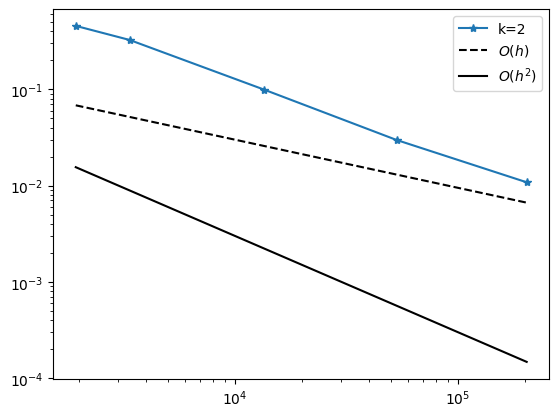

In [13]:
import matplotlib.pyplot as plt

plt.plot(ndof, l2err, "-*", label="k=" + str(order))
plt.plot(ndof, [3 / sqrt(nd) for nd in ndof], "--", color="k", label="$O(h)$")
plt.plot(ndof, [30 / sqrt(nd) ** 2 for nd in ndof], "-", color="k", label="$O(h^2)$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

### Applications
* Curvature approximation of surfaces
* Shells (bending energy) [<a href="https://arxiv.org/abs/2304.13806">Neunteufel, Schöberl: The Hellan-Herrmann-Johnson and TDNNS method for linear and nonlinear shell, <i>arXiv</i> (2023).</a>]
* Cell membranes (Canham-Helfrich-Evans bending energy) [<a href="https://doi.org/10.1016/j.jcp.2023.112218">Neunteufel, Schöberl, Sturm: Numerical shape optimization of the Canham-Helfrich-Evans bending energy, <i>J Comput Phys</i> (2023).</a>]